In [29]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

import re

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EL_Cyberbullying/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Exploratory analysis

In [5]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [6]:
#Remove duplicates per row
df.drop_duplicates(inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [8]:
pd.set_option('display.max_colwidth', None)
df_groupby_tweet=df.groupby('tweet_text').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()
df_groupby_tweet[df_groupby_tweet['cyberbullying_type']>1]

,tweet_text,cyberbullying_type
0,What a riveting little lesson in walking the catwalk. Thanks ladies #MKR,2
1,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",2
2,@NedGilmore oh! go get meat from south.,2
3,@kate_1985 - not sure!! But never fear @mykitchenrules still has 751 teams left and another Instant Restaurant round to come. #MKR,2
4,@NetTxt doesn't work that way. Sorry to disappoint you. No one cares what you want.,2
...,...,...
1634,RT @HelpIamaCabbage: @freebsdgirl People are spending money to try to get you temporarily suspended from twitter? That may be the most was…,2
1635,TODO: email tax guy to ask if lavender bath bombs qualify as a business expense.,2
1636,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",2
1637,"RT @DustyPee: If #cuntandandre make it through, I'll... I don't know what I will do. #mkr",2


In [9]:
df[df['tweet_text']=="Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"]

,tweet_text,cyberbullying_type
9109,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",gender
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying


In [10]:
df[df['tweet_text']=="@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself."]

,tweet_text,cyberbullying_type
6686,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",not_cyberbullying
29619,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",other_cyberbullying


In [11]:
#Remove duplicates based on tweet text. Keep only on cyberullying type per tweet
df.drop_duplicates(subset='tweet_text', keep="first", inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,"In other words #katandandre, your food was crapilicious! #mkr",religion
freq,1,7995


In [12]:
#Number of tweets per type of cyberbullying (after removing duplicates)
df.groupby('cyberbullying_type').count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


### Preprocess tweets

In [13]:
stemmer = SnowballStemmer("english")
stemmer.stem("studies")

'studi'

In [14]:
lematizer=WordNetLemmatizer()
lematizer.lemmatize("studies")

'study'

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lematizer=WordNetLemmatizer()

def preprocess_tweet(tweet, stem=False):
    #Remove special caracters, links and user tags
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    #Remove stopwords
    tweet=" ".join([word for word in str(tweet).split() if word not in stop_words])
    #Stemming: Removes suffixes and prefixes. Ex. studies->studi.
    if stem==True:
        tweet= " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatizing: Gets the root word (better). studies->study
    tweet=" ".join([lematizer.lemmatize(word) for word in tweet.split()])
    return tweet

In [18]:
#Preprocess tweets
df['tweet_cleaned']=df['tweet_text'].apply(preprocess_tweet)
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbour wonderlandten etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thanks head concerned another angry dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretending kurdish account like islam lie


In [19]:
df.describe()

,tweet_text,cyberbullying_type,tweet_cleaned
count,46017,46017,46017
unique,46017,6,44942
top,"In other words #katandandre, your food was crapilicious! #mkr",religion,
freq,1,7995,271


In [20]:
df.groupby('tweet_cleaned').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()

,tweet_cleaned,tweet_text,cyberbullying_type
0,,271,271
1,fuck dumb nigger,45,45
2,bully,36,36
3,yes,25,25
4,feminazi,24,24
...,...,...,...
44937,halalflaws biebervalue greenlinerzjm bitch copied hadith go look hadith bitch,1,1
44938,halalflaws biebervalue greenlinerzjm go look word taquiyya,1,1
44939,halalflaws biebervalue greenlinerzjm islamic culture islamic religion,1,1
44940,halalflaws biebervalue muslim woman treated like queen,1,1


In [21]:
#Remove empty tweets
df.dropna(subset = ["tweet_cleaned"], inplace=True)

In [22]:
df[df['tweet_cleaned']=='feminazi']
#Should be remove duplicates after cleaning tweet?

,tweet_text,cyberbullying_type,tweet_cleaned
8222,@piojaa_ feminazi,gender,feminazi
8503,@Bourgholtzer feminazi,gender,feminazi
9765,FEMINAZI,gender,feminazi
9791,'Feminazi' http://t.co/Y5skW0daNu,gender,feminazi
10138,@Fernandarova feminazi,gender,feminazi
11378,@FunkAd3 feminazi.,gender,feminazi
12134,To feminazi,gender,feminazi
12181,Feminazi (?),gender,feminazi
12385,Feminazi.,gender,feminazi
12817,Feminazi 😳,gender,feminazi


### Word cloud and common words count

Type of cyberbullying: not_cyberbullying


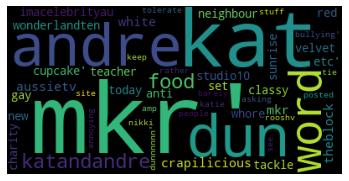

Top 10 words:
('mkr', 1612)
('rt', 794)
('bullying', 725)
('bully', 423)
('like', 408)
('school', 380)
('get', 354)
('kat', 300)
('amp', 283)
('people', 274)

Type of cyberbullying: gender


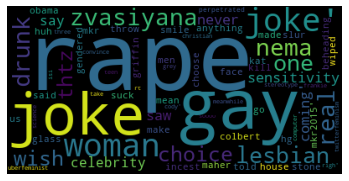

Top 10 words:
('joke', 5376)
('rape', 4304)
('gay', 4195)
('rt', 1241)
('woman', 1211)
('bitch', 1174)
('female', 1132)
('call', 1115)
('people', 1010)
('sexist', 982)

Type of cyberbullying: religion


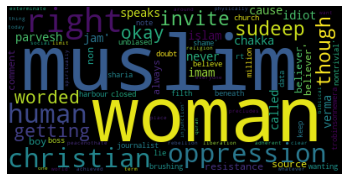

Top 10 words:
('muslim', 4868)
('idiot', 3122)
('christian', 2142)
('u', 2030)
('terrorist', 1466)
('right', 1342)
('islamic', 1285)
('woman', 1278)
('like', 1252)
('islam', 1240)

Type of cyberbullying: other_cyberbullying


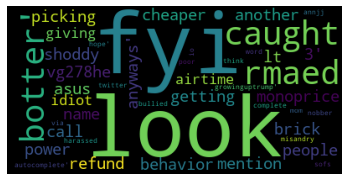

Top 10 words:
('rt', 750)
('bully', 564)
('like', 410)
('fucking', 364)
('people', 354)
('get', 306)
('idiot', 268)
('know', 236)
('u', 233)
('think', 221)

Type of cyberbullying: age


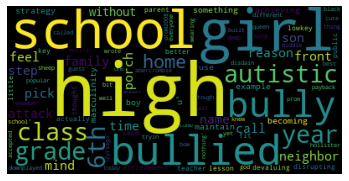

Top 10 words:
('school', 8645)
('high', 5089)
('girl', 4699)
('bully', 4403)
('bullied', 4393)
('like', 1896)
('one', 1052)
('people', 936)
('got', 827)
('kid', 816)

Type of cyberbullying: ethnicity


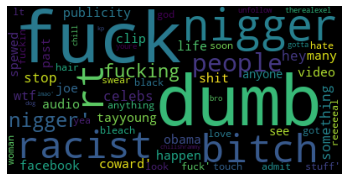

Top 10 words:
('nigger', 5798)
('fuck', 5489)
('dumb', 5215)
('as', 2281)
('black', 2203)
('u', 2167)
('white', 1604)
('rt', 1221)
('people', 1192)
('obama', 1145)



In [40]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  #Generate wordcloud
  wordcloud = WordCloud().generate(str(tweets))
  print("Type of cyberbullying:", i)
  #Display word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  #Count frequency for each word and get top 10
  top_words=Counter(" ".join(df["tweet_cleaned"][df['cyberbullying_type']==i]).split()).most_common(10)
  print("Top 10 words:", *top_words, sep = "\n")
  print("")